<a href="https://colab.research.google.com/github/LuisEduardoRB/EDP-II/blob/main/M%C3%A9todo_impl%C3%ADcito_de_Crank_nicolson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="text-align:center; font-family: 'Georgia', 'Times New Roman', serif; color:#1f2d3d;">
Método implícito de Crank-Nicolson
</h1>

<h3 style="text-align:center; font-family: 'Georgia', 'Times New Roman', serif; font-weight:400; color:#4a6278;">
Solución numérica de la ecuación del calor con condiciones de Dirichlet
</h3>

<hr style="border: 1px solid #d5d8dc; width:70%;">

<p style="text-align:center; font-family: 'Georgia', 'Times New Roman', serif; color:#7b8a8b;">
<u>Programa en Python para Ecuaciones Diferenciales Parciales</u>
</p>


## 1. Importación de librerías

En este bloque se cargan las librerías que usaremos a lo largo del cuaderno:

- **sympy**: manejo de matrices y solución de sistemas lineales de forma simbólica (usaremos `LUsolve` en Crank–Nicolson).
- **numpy**: trabajo numérico con arreglos y operaciones vectoriales/matriciales.
- **matplotlib**: generación de gráficas 2D y 3D para visualizar la solución.
- **tabulate**: impresión de tablas numéricas con formato tipo “tabla del libro”.
- **mpl_toolkits.mplot3d** y **cm**: herramientas adicionales para la gráfica 3D y el mapa de color.

Estas librerías forman la base para implementar y visualizar el método de Crank–Nicolson para la ecuación del calor.


In [6]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # necesario para 3D
from matplotlib import cm
from tabulate import tabulate

## 2. Problema de EDP y parámetros de la malla

Vamos a resolver la **ecuación del calor**:

$$
u_t = u_{xx}, \quad 0 < x < 1,\ t > 0
$$

con:

- **Condiciones de frontera** (Dirichlet homogéneas):

  $$
  u(0,t) = 0, \quad u(1,t) = 0, \quad t \ge 0
  $$

- **Condición inicial**:

  $$
  u(x,0) = 1 - 4\left(x - \tfrac{1}{2}\right)^2, \quad 0 \le x \le 1
  $$

Discretización:

- Tomamos $N = 9$ puntos interiores en $(0,1)$.
- El paso espacial es
  $$
  h = \frac{1}{N+1} = 0.1.
  $$
- Fijamos el parámetro
  $$
  r = \frac{\Delta t}{h^2} = 1,
  $$
  de donde
  $$
  \Delta t = r\,h^2 = 0.01.
  $$
- Evolucionamos hasta $T = 0.1$, de modo que los tiempos son
  $$
  t_k = k\,\Delta t, \quad k = 0,1,\dots,10.
  $$


In [7]:
# Número de puntos interiores en x
N = 9
h = 1.0 / (N + 1)                # h = 0.1
xs = np.linspace(h, 1 - h, N)    # puntos interiores: 0.1,...,0.9

# Parámetro r = dt / h^2 y paso temporal
r = 1.0
dt = r * h**2                    # dt = 0.01
T = 0.1                          # tiempo final para las tablas (t = 0.10)
nsteps = int(round(T / dt))      # número de pasos de tiempo: 10
ts = np.linspace(0, nsteps*dt, nsteps+1)

## 3. Condición inicial \(f(x)\)

Definimos la función:

$$
u(x,0) = f(x) = 1 - 4\left(x - \tfrac{1}{2}\right)^2.
$$

Esta función describe el perfil inicial de la solución en el intervalo \([0,1]\).

- Entrada: un valor de \(x \in [0,1]\).
- Salida: el valor de \(u(x,0)\) en ese punto.

Luego usaremos \(f(x)\) para construir el vector de valores iniciales \(u^0\)
en los puntos interiores de la malla.


In [8]:
def f(x):
    return 1 - 4*(x-0.5)**2

## 4. Construcción de las matrices \(A\) y \(B\)

Usamos el esquema de **Crank–Nicolson**:

$$
\left(I + \frac{r}{2}L\right)u^{k+1} = \left(I - \frac{r}{2}L\right)u^{k},
$$

donde \(L\) es la matriz tridiagonal que aproxima \(u_{xx}\) en los puntos interiores.

Multiplicando todo por 2, escribimos:

$$
A\,u^{k+1} = B\,u^{k},
$$

con:

- Matriz \(A\): diagonal \(2 + 2r\) y sub/superdiagonal \(-r\).
- Matriz \(B\): diagonal \(2 - 2r\) y sub/superdiagonal \(r\).

Estas matrices actúan solo sobre los puntos interiores; en las fronteras
se impone \(u(0,t) = u(1,t) = 0\).


In [9]:
A = sp.zeros(N)
for i in range(N):
    A[i, i] = 2 + 2*r
for i in range(N-1):
    A[i, i+1] = -r
    A[i+1, i] = -r

B = sp.zeros(N)
for i in range(N):
    B[i, i] = 2 - 2*r
for i in range(N-1):
    B[i, i+1] = r
    B[i+1, i] = r

## 5. Vector de condición inicial \(u^0\)

Construimos el vector columna \(u^0\) evaluando la condición inicial
en los \(N\) puntos interiores:

$$
x_i = i\,h, \quad i = 1,2,\dots,N.
$$

Cada componente es:

$$
u^0_i = u(x_i,0) = f(x_i).
$$

Este vector será el estado inicial que alimenta el esquema de Crank–Nicolson.


In [10]:
u0_sym = sp.Matrix([f(h*(i+1)) for i in range(N)])

## 6. Función `crank_nicolson(A, B, u0, nsteps)`

Esta función implementa el método de Crank–Nicolson para

$$
u_t = u_{xx},
$$

con condiciones de frontera

$$
u(0,t) = u(1,t) = 0.
$$

El esquema numérico es:

$$
A\,u^{k+1} = B\,u^{k}, \quad k = 0,1,\dots,\text{nsteps}-1,
$$

donde \(u^k\) es el vector de valores en los puntos interiores en el tiempo \(t_k\).

- Parámetros:
  - \(A\): matriz \(N\times N\).
  - \(B\): matriz \(N\times N\).
  - \(u^0\): vector columna de tamaño \(N\).
  - `nsteps`: número de pasos de tiempo.

- Salida:
  - Matriz \(U \in \mathbb{R}^{(\text{nsteps}+1)\times N}\) tal que
    \(U[k,i] \approx u(x_i,t_k)\).

Esta matriz \(U\) se usará para tablas y gráficas.


In [11]:
def crank_nicolson(A, B, u0, nsteps):
    U = []
    # fila inicial: condición inicial u^0
    U.append(np.array(u0, dtype=float).reshape(-1))

    # RHS inicial B * u^0
    rhs = B * u0
    for k in range(nsteps):
        # Resolver A u^{k+1} = rhs usando LU de sympy
        u_next = A.LUsolve(rhs)
        U.append(np.array(u_next, dtype=float).reshape(-1))
        # Actualizar RHS para el siguiente paso: B u^{k+1}
        rhs = B * u_next

    return np.array(U)

## 7. Cálculo de la solución numérica \(U\)

Llamamos a `crank_nicolson` para obtener la solución aproximada en todos
los tiempos \(t_k\) y puntos interiores \(x_i\):

$$
U =
\begin{pmatrix}
(u^0)^\top \\
(u^1)^\top \\
\vdots \\
(u^{\text{nsteps}})^\top
\end{pmatrix}.
$$


In [12]:
U = crank_nicolson(A, B, u0_sym, nsteps)

## 8. Función `u_exacta(x, t, n_terms=50)`

La solución exacta del problema

- \(u_t = u_{xx}\),
- \(u(0,t) = u(1,t) = 0\),
- \(u(x,0) = 1 - 4\left(x - \tfrac{1}{2}\right)^2\),

se escribe como serie de Fourier:

$$
u(x,t) =
\sum_{\substack{m=1 \\ m\ \text{impar}}}^{\infty}
\frac{32}{m^3 \pi^3}\,e^{-(m\pi)^2 t}\,\sin(m\pi x).
$$

En la práctica truncamos la suma a `n_terms` términos impares.

La función `u_exacta` evalúa esta serie (truncada) en uno o varios puntos \(x\)
y en un tiempo \(t\).


In [13]:
def u_exacta(x, t, n_terms=50):
    x = np.array(x, dtype=float)
    res = np.zeros_like(x, dtype=float)
    for k in range(n_terms):
        m = 2*k + 1                    # solo m impares
        coef = 32.0 / (m**3 * np.pi**3)
        res += coef * np.exp(-(m*np.pi)**2 * t) * np.sin(m*np.pi * x)
    return res

## 9. Tabla 2.6 – Aproximación numérica (Crank–Nicolson)

Mostramos la solución numérica en una malla reducida:

- Tiempos:
  $$
  t = 0,\ 0.01,\ \dots,\ 0.10.
  $$
- Posiciones:
  $$
  x = 0,\ 0.1,\ 0.2,\ 0.3,\ 0.4,\ 0.5.
  $$

En \(x=0\) usamos \(u(0,t)=0\); los demás valores salen de la matriz \(U\).
La tabla se imprime con `tabulate` para imitar el estilo de un texto de EDP.


In [14]:
xs_tab = np.linspace(0.0, 0.5, 6)   # 0, 0.1, ..., 0.5
headers = ["t", "x=0", "0.1", "0.2", "0.3", "0.4", "0.5"]

table_num = []
for k, t in enumerate(ts):
    # valor en x=0 es siempre 0 (Dirichlet)
    row_vals = [0.0]
    # puntos interiores x=0.1,...,0.5 corresponden a índices 0..4 de U
    row_vals.extend(U[k, 0:5])
    # formateo de los valores
    row = [f"{t:.2f}"] + [f"{val:.4f}" for val in row_vals]
    table_num.append(row)

print("Tabla 2.6: Aproximación numérica (Crank–Nicolson)")
print(tabulate(table_num, headers=headers, tablefmt="grid"))

Tabla 2.6: Aproximación numérica (Crank–Nicolson)
+------+-------+--------+--------+--------+--------+--------+
|    t |   x=0 |    0.1 |    0.2 |    0.3 |    0.4 |    0.5 |
+======+=======+========+========+========+========+========+
| 0    |     0 | 0.36   | 0.64   | 0.84   | 0.96   | 1      |
+------+-------+--------+--------+--------+--------+--------+
| 0.01 |     0 | 0.3014 | 0.5657 | 0.7615 | 0.8804 | 0.9202 |
+------+-------+--------+--------+--------+--------+--------+
| 0.02 |     0 | 0.2676 | 0.5048 | 0.6885 | 0.803  | 0.8417 |
+------+-------+--------+--------+--------+--------+--------+
| 0.03 |     0 | 0.2399 | 0.4548 | 0.6231 | 0.73   | 0.7665 |
+------+-------+--------+--------+--------+--------+--------+
| 0.04 |     0 | 0.2164 | 0.411  | 0.5646 | 0.6626 | 0.6963 |
+------+-------+--------+--------+--------+--------+--------+
| 0.05 |     0 | 0.1958 | 0.3721 | 0.5117 | 0.6011 | 0.6319 |
+------+-------+--------+--------+--------+--------+--------+
| 0.06 |     0 | 0.1

## 10. Tabla 2.7 – Valores exactos

Construimos una tabla análoga usando la solución exacta \(u(x,t)\).

Usamos los mismos tiempos

$$
t = 0,\ 0.01,\ \dots,\ 0.10
$$

y los mismos puntos espaciales

$$
x = 0,\ 0.1,\ 0.2,\ 0.3,\ 0.4,\ 0.5.
$$

Comparando esta tabla con la numérica podemos evaluar el error del método.


In [15]:
table_exact = []
for k, t in enumerate(ts):
    u_ex_tab = u_exacta(xs_tab, t)     # incluye x=0,...,0.5
    row = [f"{t:.2f}"] + [f"{val:.4f}" for val in u_ex_tab]
    table_exact.append(row)

print("\nTabla 2.7: Valores exactos")
print(tabulate(table_exact, headers=headers, tablefmt="grid"))


Tabla 2.7: Valores exactos
+------+-------+--------+--------+--------+--------+--------+
|    t |   x=0 |    0.1 |    0.2 |    0.3 |    0.4 |    0.5 |
+======+=======+========+========+========+========+========+
| 0    |     0 | 0.36   | 0.64   | 0.84   | 0.96   | 1      |
+------+-------+--------+--------+--------+--------+--------+
| 0.01 |     0 | 0.3024 | 0.5645 | 0.7606 | 0.8801 | 0.92   |
+------+-------+--------+--------+--------+--------+--------+
| 0.02 |     0 | 0.2671 | 0.5041 | 0.6873 | 0.8019 | 0.8408 |
+------+-------+--------+--------+--------+--------+--------+
| 0.03 |     0 | 0.2393 | 0.4537 | 0.6218 | 0.7284 | 0.7649 |
+------+-------+--------+--------+--------+--------+--------+
| 0.04 |     0 | 0.2158 | 0.4098 | 0.5629 | 0.6607 | 0.6943 |
+------+-------+--------+--------+--------+--------+--------+
| 0.05 |     0 | 0.1951 | 0.3708 | 0.5099 | 0.599  | 0.6296 |
+------+-------+--------+--------+--------+--------+--------+
| 0.06 |     0 | 0.1766 | 0.3357 | 0.4619 

## 11. Comparación numérica vs exacta en \(t = 0.1\)

Tomamos el tiempo final \(T = 0.1\) y comparamos:

$$
u_{\text{num}}(x_i,T) = U[\text{nsteps}, i],
\qquad
u_{\text{ex}}(x_i,T) = u_{\text{exacta}}(x_i,T).
$$

Graficamos ambas curvas en función de \(x\) para visualizar el error
en los nodos de la malla.


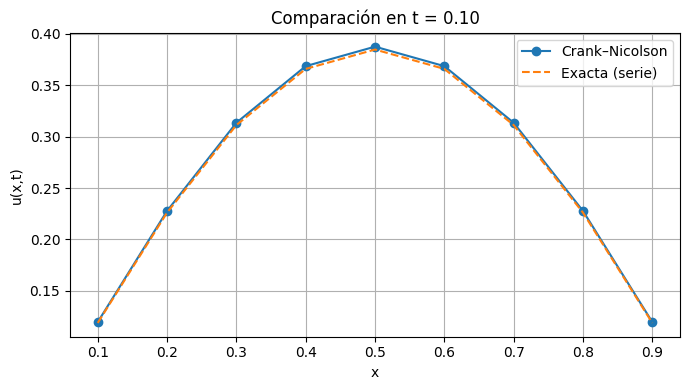

In [16]:
k_plot = nsteps          # último tiempo t = T = 0.1
t_plot = ts[k_plot]

u_num = U[k_plot, :]
u_ex = u_exacta(xs, t_plot)

plt.figure(figsize=(7, 4))
plt.plot(xs, u_num, 'o-', label='Crank–Nicolson')
plt.plot(xs, u_ex, '--', label='Exacta (serie)')
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title(f'Comparación en t = {t_plot:.2f}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 12. Gráfico de contornos de \(u(x,t)\)

Representamos la solución numérica en el plano \((x,t)\):

- eje horizontal: \(x\),
- eje vertical: \(t\),
- el color indica el valor de \(u(x,t)\).

El gráfico muestra cómo la distribución inicial se va suavizando
por la acción del operador difusivo \(u_{xx}\).


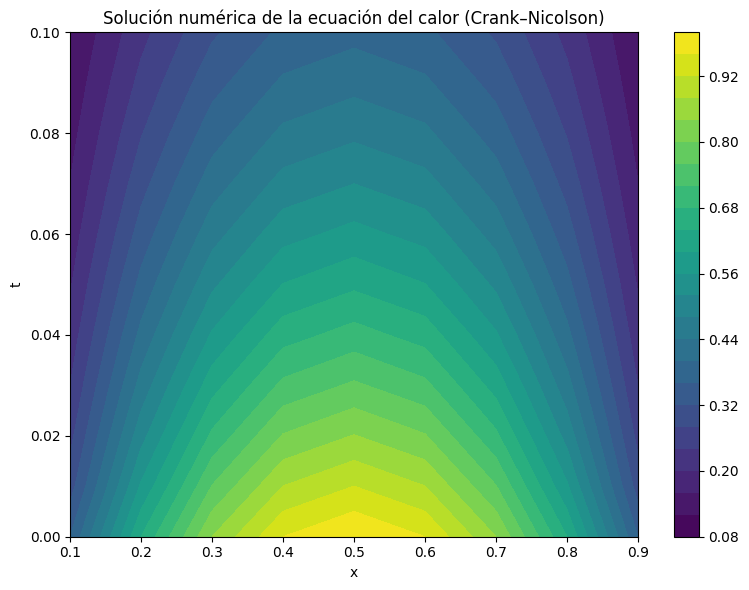

In [17]:
X, Tmesh = np.meshgrid(xs, ts)

plt.figure(figsize=(8, 6))
contour = plt.contourf(X, Tmesh, U, levels=25, cmap=cm.viridis)
plt.colorbar(contour)
plt.title('Solución numérica de la ecuación del calor (Crank–Nicolson)')
plt.xlabel('x')
plt.ylabel('t')
plt.tight_layout()
plt.show()

## 13. Gráfico 3D de la superficie \(u(x,t)\)

Mostramos la solución numérica como una superficie:

- eje \(x\): posición espacial,
- eje \(y\): tiempo,
- eje \(z\): valor de \(u(x,t)\).

Este gráfico da una visión global de la evolución temporal de la solución
de la ecuación del calor en el intervalo \((0,1)\).


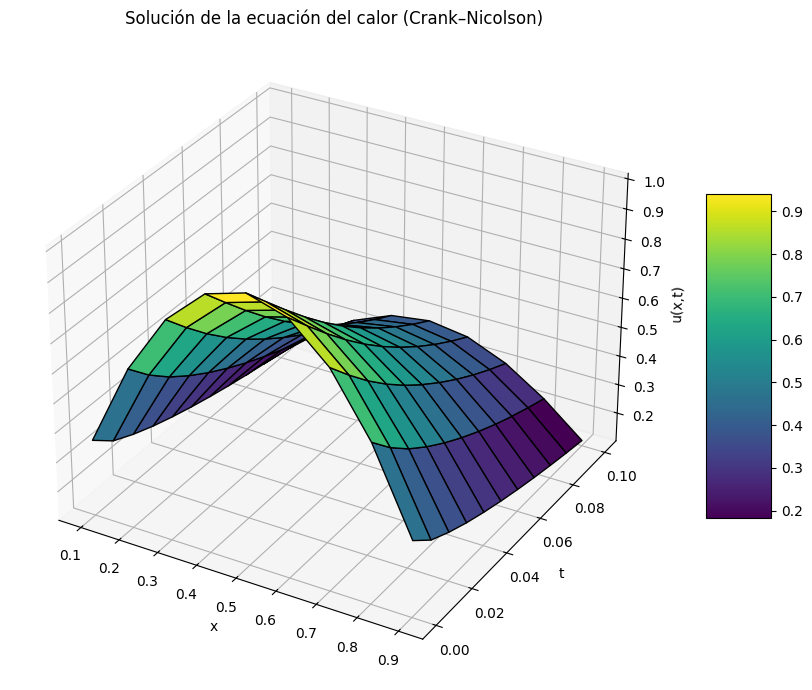

In [18]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Tmesh, U, cmap=cm.viridis, edgecolor='k')
ax.set_title('Solución de la ecuación del calor (Crank–Nicolson)')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u(x,t)')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.tight_layout()
plt.show()